### Predicting Inssurance Premium 

### Activate pyspark

In [111]:
# This is important to run at the begenning
import findspark
findspark.init()

In [112]:
## Start SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lr_example').getOrCreate()

### Read data

In [113]:
datapath ='C:\\Users\\sshrestha002\\Documents\data\\'
data = spark.read.csv(datapath+'insurance.csv', header=True, inferSchema=True)

In [114]:
# gender, smoker and region are strings
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- expenses: double (nullable = true)



In [115]:
data.count()

1338

In [116]:
data.show(2)

+---+------+----+--------+------+---------+--------+
|age|gender| bmi|children|smoker|   region|expenses|
+---+------+----+--------+------+---------+--------+
| 19|female|27.9|       0|   yes|southwest|16884.92|
| 18|  male|33.8|       1|    no|southeast| 1725.55|
+---+------+----+--------+------+---------+--------+
only showing top 2 rows



In [117]:
data.toPandas().head(5)

,age,gender,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### EDA

In [118]:
## Summary stat
data.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1338,39.20702541106129,14.049960379216147,18,64
gender,1338,None,None,female,male
bmi,1338,30.665470852017993,6.09838219000336,16.0,53.1
children,1338,1.0949177877429,1.205492739781914,0,5
smoker,1338,None,None,no,yes
region,1338,None,None,northeast,southwest
expenses,1338,13270.422414050803,12110.011239706473,1121.87,63770.43


In [119]:
# Check Null
from pyspark.sql.functions import isnan, when, count, col
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+------+---+--------+------+------+--------+
|age|gender|bmi|children|smoker|region|expenses|
+---+------+---+--------+------+------+--------+
|  0|     0|  0|       0|     0|     0|       0|
+---+------+---+--------+------+------+--------+



In [120]:
# Check distribution of categorical variables
data.groupBy(data.gender).count().show()

+------+-----+
|gender|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+



In [121]:
data.groupBy(data.children).count().show()

+--------+-----+
|children|count|
+--------+-----+
|       1|  324|
|       3|  157|
|       5|   18|
|       4|   25|
|       2|  240|
|       0|  574|
+--------+-----+



In [122]:
data.groupBy(data.region).count().show()

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  325|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



### StringIndexer, OneHotEncoder, VectorAssembler

In [123]:
# gender, smoker and region are strings
data.columns

['age', 'gender', 'bmi', 'children', 'smoker', 'region', 'expenses']

In [124]:
# Import
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler)

In [125]:
# For all categorical variables, convert categories to numbers
gender_indexer = StringIndexer(inputCol = 'gender', outputCol='genderNum')
smoker_indexer = StringIndexer(inputCol = 'smoker', outputCol='smokerNum')
region_indexer = StringIndexer(inputCol = 'region', outputCol='regionNum')
data = gender_indexer.fit(data).transform(data)
data = smoker_indexer.fit(data).transform(data)
data = region_indexer.fit(data).transform(data)

In [126]:
data.show(3)

+---+------+----+--------+------+---------+--------+---------+---------+---------+
|age|gender| bmi|children|smoker|   region|expenses|genderNum|smokerNum|regionNum|
+---+------+----+--------+------+---------+--------+---------+---------+---------+
| 19|female|27.9|       0|   yes|southwest|16884.92|      1.0|      1.0|      2.0|
| 18|  male|33.8|       1|    no|southeast| 1725.55|      0.0|      0.0|      0.0|
| 28|  male|33.0|       3|    no|southeast| 4449.46|      0.0|      0.0|      0.0|
+---+------+----+--------+------+---------+--------+---------+---------+---------+
only showing top 3 rows



In [127]:
# For all converted numeric form, now change to one hot encoded column
gender_encoder = OneHotEncoder(inputCol = 'genderNum', outputCol='genderVec')
smoker_encoder = OneHotEncoder(inputCol = 'smokerNum', outputCol='smokerVec')
region_encoder = OneHotEncoder(inputCol = 'regionNum', outputCol='regionVec')
onehotdata = gender_encoder.fit(data).transform(data)
onehotdata = smoker_encoder.fit(onehotdata).transform(onehotdata)
onehotdata = region_encoder.fit(onehotdata).transform(onehotdata)

In [128]:
onehotdata.show(3)

+---+------+----+--------+------+---------+--------+---------+---------+---------+-------------+-------------+-------------+
|age|gender| bmi|children|smoker|   region|expenses|genderNum|smokerNum|regionNum|    genderVec|    smokerVec|    regionVec|
+---+------+----+--------+------+---------+--------+---------+---------+---------+-------------+-------------+-------------+
| 19|female|27.9|       0|   yes|southwest|16884.92|      1.0|      1.0|      2.0|    (1,[],[])|    (1,[],[])|(3,[2],[1.0])|
| 18|  male|33.8|       1|    no|southeast| 1725.55|      0.0|      0.0|      0.0|(1,[0],[1.0])|(1,[0],[1.0])|(3,[0],[1.0])|
| 28|  male|33.0|       3|    no|southeast| 4449.46|      0.0|      0.0|      0.0|(1,[0],[1.0])|(1,[0],[1.0])|(3,[0],[1.0])|
+---+------+----+--------+------+---------+--------+---------+---------+---------+-------------+-------------+-------------+
only showing top 3 rows



In [129]:
print(onehotdata.columns)

['age', 'gender', 'bmi', 'children', 'smoker', 'region', 'expenses', 'genderNum', 'smokerNum', 'regionNum', 'genderVec', 'smokerVec', 'regionVec']


In [130]:
# Assembler all columns into a vector 
assembler = VectorAssembler(
    inputCols=['age','bmi','children','genderVec','smokerVec','regionVec'],
    outputCol='features')
output = assembler.transform(onehotdata)

In [131]:
output.show(3)

+---+------+----+--------+------+---------+--------+---------+---------+---------+-------------+-------------+-------------+--------------------+
|age|gender| bmi|children|smoker|   region|expenses|genderNum|smokerNum|regionNum|    genderVec|    smokerVec|    regionVec|            features|
+---+------+----+--------+------+---------+--------+---------+---------+---------+-------------+-------------+-------------+--------------------+
| 19|female|27.9|       0|   yes|southwest|16884.92|      1.0|      1.0|      2.0|    (1,[],[])|    (1,[],[])|(3,[2],[1.0])|(8,[0,1,7],[19.0,...|
| 18|  male|33.8|       1|    no|southeast| 1725.55|      0.0|      0.0|      0.0|(1,[0],[1.0])|(1,[0],[1.0])|(3,[0],[1.0])|[18.0,33.8,1.0,1....|
| 28|  male|33.0|       3|    no|southeast| 4449.46|      0.0|      0.0|      0.0|(1,[0],[1.0])|(1,[0],[1.0])|(3,[0],[1.0])|[28.0,33.0,3.0,1....|
+---+------+----+--------+------+---------+--------+---------+---------+---------+-------------+-------------+-------------+

In [132]:
# Create a final data with features and Y column : expenses
finaldata = output.select('features','expenses')
finaldata.show(3)

+--------------------+--------+
|            features|expenses|
+--------------------+--------+
|(8,[0,1,7],[19.0,...|16884.92|
|[18.0,33.8,1.0,1....| 1725.55|
|[28.0,33.0,3.0,1....| 4449.46|
+--------------------+--------+
only showing top 3 rows



### Split data


In [133]:
train,test = finaldata.randomSplit([0.7,0.3], seed=2040)
print('Training size', train.count())
print('Testing size', test.count())

Training size 929
Testing size 409


In [173]:
## Summary stat
train.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
expenses,929,13217.489429494099,12226.787074462132,1121.87,63770.43


In [175]:
## Summary stat
test.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
expenses,409,13390.65405867973,11854.404262558885,1242.26,49577.66


### linear Regression

In [134]:
# Import 
from pyspark.ml.regression import LinearRegression, LinearRegressionModel, RandomForestRegressionModel

In [135]:
# Fit the model
linreg = LinearRegression(featuresCol='features', labelCol='expenses')
lr_model = linreg.fit(train)

In [136]:
# Print coefficients
print('Intercept :\n', lr_model.intercept)
print('Coefficients :\n', lr_model.coefficients)

Intercept :
 11916.1337364216
Coefficients :
 [268.39197284742806,334.68082799521943,477.31295799455654,274.73975503652383,-24300.556923781278,-958.4305098250376,-355.41109363634865,-1167.3186319849897]


#### Format results to create a nice output table

In [137]:
outdata = lr_model.transform(train)
numericdata = outdata.select('features').schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
binarydata = outdata.select('features').schema[0].metadata.get('ml_attr').get('attrs').get('binary')
merged_list = numericdata+binarydata

In [138]:
merged_list

[{'idx': 0, 'name': 'age'},
 {'idx': 1, 'name': 'bmi'},
 {'idx': 2, 'name': 'children'},
 {'idx': 3, 'name': 'genderVec_male'},
 {'idx': 4, 'name': 'smokerVec_no'},
 {'idx': 5, 'name': 'regionVec_southeast'},
 {'idx': 6, 'name': 'regionVec_northwest'},
 {'idx': 7, 'name': 'regionVec_southwest'}]

In [139]:
# Create a pandas df
import pandas as pd
result = pd.DataFrame(merged_list)
result

,idx,name
0,0,age
1,1,bmi
2,2,children
3,3,genderVec_male
4,4,smokerVec_no
5,5,regionVec_southeast
6,6,regionVec_northwest
7,7,regionVec_southwest


In [140]:
# Add other stats
result['coefficients'] = lr_model.coefficients
result.loc[len(result.index)] = ['', 'Intercept', lr_model.intercept]

trainingSummary = lr_model.summary
result['StdErr'] = trainingSummary.coefficientStandardErrors
result['t-value'] = trainingSummary.tValues
result['p-Value'] = trainingSummary.pValues

In [141]:
result

,idx,name,coefficients,StdErr,t-value,p-Value
0,0,age,268.391973,14.573079,18.416971,0.000000
1,1,bmi,334.680828,35.249062,9.494744,0.000000
2,2,children,477.312958,174.719054,2.731888,0.006418
3,3,genderVec_male,274.739755,409.769061,0.670475,0.502724
4,4,smokerVec_no,-24300.556924,517.795015,-46.930844,0.000000
5,5,regionVec_southeast,-958.430510,590.778618,-1.622318,0.105078
6,6,regionVec_northwest,-355.411094,591.829733,-0.600529,0.548301
7,7,regionVec_southwest,-1167.318632,587.845607,-1.985757,0.047357
8,,Intercept,11916.133736,1282.144173,9.293911,0.000000


### Evaluate

In [142]:
trainresult = lr_model.evaluate(train)
testresult = lr_model.evaluate(test)

In [143]:
print('RMSE on traindata :', trainresult.rootMeanSquaredError)
print('RMSE on testdata :', testresult.rootMeanSquaredError)

print('R2 on traindata :', trainresult.r2)
print('R2 on testdata :', testresult.r2)

RMSE on traindata : 6179.168022540979
RMSE on testdata : 5754.937235997628
R2 on traindata : 0.7443162962944101
R2 on testdata : 0.7637429043673949


### VIF Calculation

In [144]:
def get_vif(data, features_list):
    vif=[]
    for i in features_list:
        temp_features = features_list.copy()
        temp_features.remove(i)
        temp_target = i
        assembler = VectorAssembler(inputCols=temp_features, outputCol='x_features')
        temp_df = assembler.transform(data)
        reg = LinearRegression(featuresCol='x_features', labelCol=i)
        reg_model = reg.fit(temp_df)
        temp_vif = 1/(1-reg_model.summary.r2)
        vif.append(temp_vif)
    return vif
data_sel = data.select('age', 'genderNum','smokerNum','children','regionNum','bmi')

In [145]:
print(data.columns)

['age', 'gender', 'bmi', 'children', 'smoker', 'region', 'expenses', 'genderNum', 'smokerNum', 'regionNum']


In [148]:
data_sel = data.select('age', 'genderNum','smokerNum','children','regionNum','bmi')

In [149]:
features_all = data_sel.columns

In [150]:
get_vif(data_sel, features_all)

[1.0162959797371278,
 1.0088903065085382,
 1.0079321173707683,
 1.0022432774934356,
 1.0505831338762388,
 1.064159440508893]

### Random Forest

In [163]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
rf = RandomForestRegressor(featuresCol='features', labelCol='expenses')
rf_model = rf.fit(train)

#### RF: Predict

In [161]:
rf_trainpred = rf_model.transform(train)
rf_testpred = rf_model.transform(test)

In [172]:
r2evaluator = RegressionEvaluator(labelCol='expenses', predictionCol='prediction', metricName='r2')
rfTrainR2 = r2evaluator.evaluate(rf_trainpred)
print('R2 Train data: ', rfTrainR2)

rfTestR2 = r2evaluator.evaluate(rf_testpred)
print('R2 Test data: ', rfTestR2)

rmseevaluator = RegressionEvaluator(labelCol='expenses', predictionCol='prediction', metricName='rmse')
rfTrainRMSE = rmseevaluator.evaluate(rf_trainpred)
print('RMSE Train data: ', rfTrainRMSE)

rfTestRMSE = rmseevaluator.evaluate(rf_testpred)
print('RMSE Test data: ', rfTestRMSE)

R2 Train data:  0.8452840454376627
R2 Test data:  0.8673480528278091
RMSE Train data:  4806.689081215364
RMSE Test data:  4312.260375424029


In [176]:
rf_trainpred.show(2)

+--------------------+--------+------------------+
|            features|expenses|        prediction|
+--------------------+--------+------------------+
|(8,[0,1],[18.0,21...|14283.46|16430.379412496033|
|(8,[0,1],[24.0,20...|14571.89| 16950.86419188861|
+--------------------+--------+------------------+
only showing top 2 rows



In [182]:
featureimp = rf_model.featureImportances
featureimp

SparseVector(8, {0: 0.1113, 1: 0.1159, 2: 0.0168, 3: 0.007, 4: 0.7343, 5: 0.0064, 6: 0.0046, 7: 0.0036})

In [183]:
rf_trainpred.select('features').schema[0].metadata.get('ml_attr')

{'attrs': {'numeric': [{'idx': 0, 'name': 'age'},
   {'idx': 1, 'name': 'bmi'},
   {'idx': 2, 'name': 'children'}],
  'binary': [{'idx': 3, 'name': 'genderVec_male'},
   {'idx': 4, 'name': 'smokerVec_no'},
   {'idx': 5, 'name': 'regionVec_southeast'},
   {'idx': 6, 'name': 'regionVec_northwest'},
   {'idx': 7, 'name': 'regionVec_southwest'}]},
 'num_attrs': 8}

In [205]:
num_data = rf_trainpred.select('features').schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
bin_data = rf_trainpred.select('features').schema[0].metadata.get('ml_attr').get('attrs').get('binary')
merge_list = num_data + bin_data
merge_list

[{'idx': 0, 'name': 'age'},
 {'idx': 1, 'name': 'bmi'},
 {'idx': 2, 'name': 'children'},
 {'idx': 3, 'name': 'genderVec_male'},
 {'idx': 4, 'name': 'smokerVec_no'},
 {'idx': 5, 'name': 'regionVec_southeast'},
 {'idx': 6, 'name': 'regionVec_northwest'},
 {'idx': 7, 'name': 'regionVec_southwest'}]

In [206]:
feature_list = pd.DataFrame(merge_list)
feature_list

,idx,name
0,0,age
1,1,bmi
2,2,children
3,3,genderVec_male
4,4,smokerVec_no
5,5,regionVec_southeast
6,6,regionVec_northwest
7,7,regionVec_southwest


In [204]:
#feature_list["Importance"] = rf_model.featureImportances

In [207]:
importance = list(rf_model.featureImportances)
importance

[0.11133389994726273,
 0.11592827067567313,
 0.016796210963029072,
 0.007038462402084077,
 0.7343010579663432,
 0.006413506303971288,
 0.0045605766902042915,
 0.003628015051432368]

In [208]:
# Get feature imp and attach to result
feature_list['Importance'] = importance
feature_list.sort_values("Importance", ascending=False, inplace=True)
feature_list

,idx,name,Importance
4,4,smokerVec_no,0.734301
1,1,bmi,0.115928
0,0,age,0.111334
2,2,children,0.016796
3,3,genderVec_male,0.007038
5,5,regionVec_southeast,0.006414
6,6,regionVec_northwest,0.004561
7,7,regionVec_southwest,0.003628


In [212]:
#!pip install matplotlib

In [213]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Features')

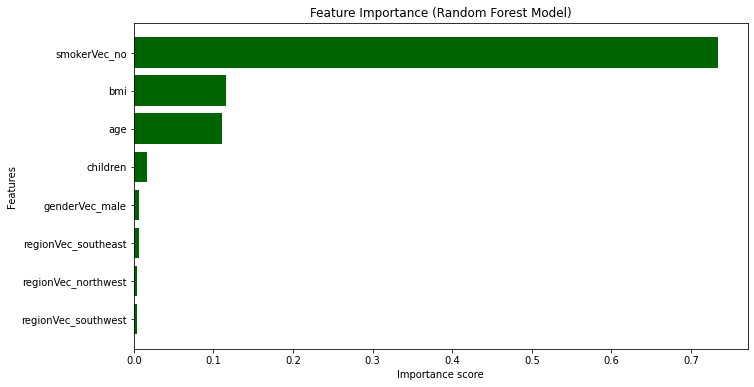

In [225]:
feature_list.sort_values("Importance", ascending=True, inplace=True)
plt.figure(figsize=(11,6))
plt.barh(feature_list['name'], feature_list['Importance'], color='darkgreen')
plt.title('Feature Importance (Random Forest Model)')
plt.xlabel('Importance score')
plt.ylabel('Features')

### END END END